<a href="https://colab.research.google.com/github/whkaikai/AI/blob/main/chapter12_part04_variational_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was generated for TensorFlow 2.6.
Implementing a VAE with Keras

# **VAE encoder network**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
#输入图像最终被编码为这两个参数
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

接下来的代码将使用 z_mean 和 z_log_var 来生成一个潜在空间点 z，z_mean 和 z_log_
var 是统计分布的参数，我们假设这个分布能够生成 input_img。这里，我们将一些随意的代
码（这些代码构建于 Keras 后端之上）包装到 Lambda 层中。在 Keras 中，任何对象都应该是一个层，所以如果代码不是内置层的一部分，我们应该将其包装到一个 Lambda 层（或自定义层）中。

In [2]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

#**Latent-space-sampling layer**

In [3]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE decoder network
mapping latent space points to images

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
#对输入进行采样
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
#将 z 转换为特征图，使其形状与编码器模型最后一个 Flatten 层之前的特征图的形状相同
x = layers.Reshape((7, 7, 64))(x)
#使用2个 Conv2DTranspose 层，将 z 解码为与原始输入图像具有相同尺寸的特征图
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
#将解码器模型实例化，它将 decoder_input转换为解码后的图像
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
#将这个实例应用于 z，以得到解码后的 z
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

##VAE model with custom `train_step()`

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# **Training the VAE**

In [7]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 176s 322ms/step - total_loss: 207.7844 - reconstruction_loss: 205.6186 - kl_loss: 2.1654
Epoch 2/30
547/547 [==============================] - 164s 299ms/step - total_loss: 165.4440 - reconstruction_loss: 162.3853 - kl_loss: 3.0587
Epoch 3/30
547/547 [==============================] - 186s 340ms/step - total_loss: 158.5645 - reconstruction_loss: 155.3975 - kl_loss: 3.1670
Epoch 4/30
547/547 [==============================] - 162s 296ms/step - total_loss: 155.5056 - reconstruction_loss: 152.2332 - kl_loss: 3.2724
Epoch 5/30
547/547 [==============================] - 162s 295ms/step - total_loss: 153.5996 - reconstruction_loss: 150.2900 - kl_loss: 3.3096
Epoch 6/30
547/547 [==============================] - 161s 294ms/step - total_loss: 152.3477 - reconstruction_loss: 148.9838 - kl_loss: 3.3639
Epoch 7/30
547/547 [==============================] - 161s 294ms/step - total

#**Sampling a grid of images from the 2D latent space**

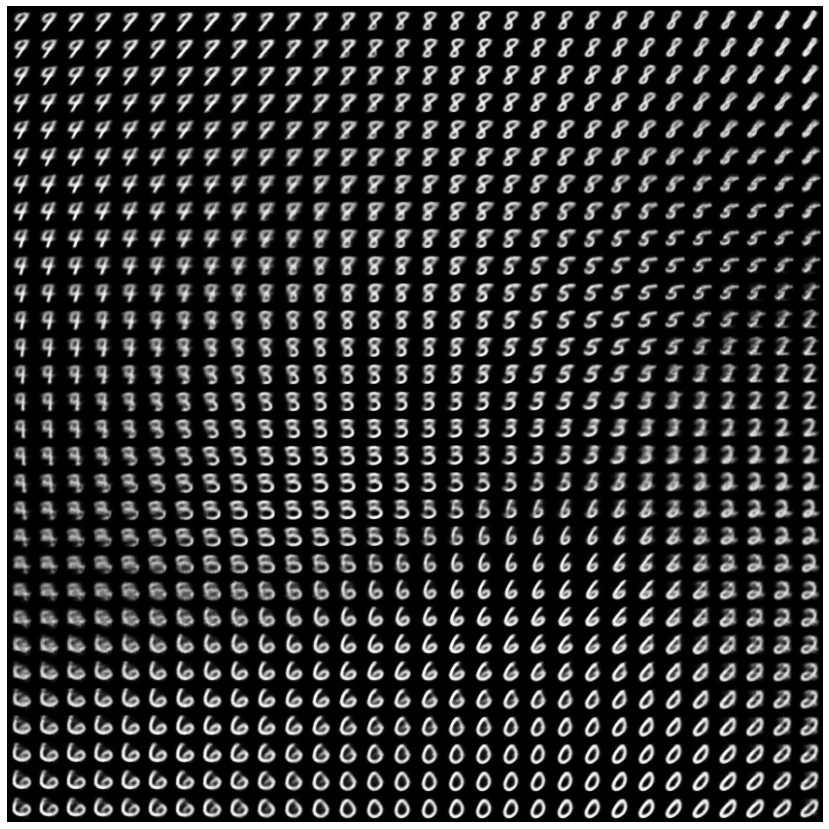

In [8]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")